# U^2-Net

In [1]:
!pip3 install keras-unet-collection
!pip3 install pynrrd
!pip install tensorflow-addons
!python -m pip install typing-extensions --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0


In [3]:
import sys
sys.path.append("../dataset/")

from dataset import UltraSoundImages
from utils import plot_history

In [4]:
from keras_unet_collection import models
import glob
import nrrd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img

In [5]:
raw_dir = "../RawUSGimagesNRRD"
raw_images = raw_dir + "/data_output"
raw_masks = raw_dir + "/masks"

raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
raw_masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

TEST_LEN = 10
VAL_LEN = 60
TRAIN_LEN = len(raw_images_paths) - VAL_LEN - TEST_LEN

train_images = raw_images_paths[:TRAIN_LEN]
validation_images = raw_images_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
test_images =  raw_images_paths[-TEST_LEN:]

train_masks = raw_masks_paths[:TRAIN_LEN]
validation_masks = raw_masks_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
test_masks =  raw_masks_paths[-TEST_LEN:]

In [6]:
train_gen = UltraSoundImages(2, train_images, train_masks, size=(512,512))
val_gen = UltraSoundImages(2, validation_images, validation_masks, size=(512,512))
test_gen = UltraSoundImages(2, test_images, test_masks, size=(512,512))

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading


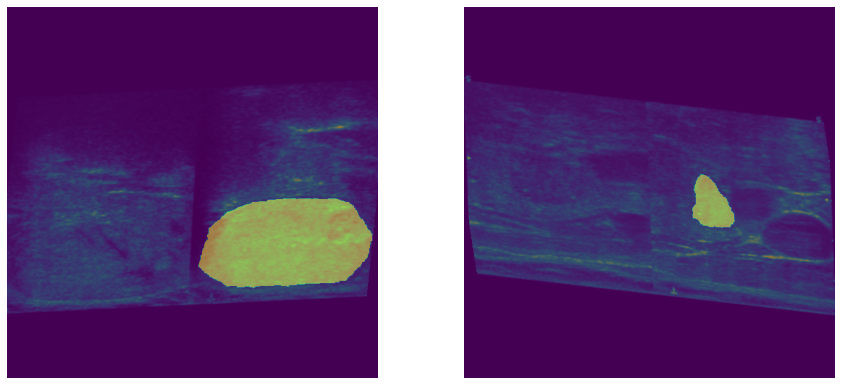

In [7]:
images, masks = train_gen.__getitem__(0)
# images, masks = val_gen.__getitem__(0)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30, # Must be more than 10!
    restore_best_weights=True
)

In [9]:
class ImagesInterCheckpoint(tf.keras.callbacks.Callback):

    def __init__(self, input_image, every_n_epoch=10):
        super(ImagesInterCheckpoint, self).__init__()
        self.every_n_epoch = every_n_epoch
        self.input_image = input_image
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.every_n_epoch == 0:
            output_mask = self.model.predict(np.expand_dims(self.input_image, axis=[0,3]))[0]
            output_mask = (output_mask*255).astype('int')
            save_img(f'images/pred_{epoch}.png', output_mask)

image = images[0]
images_inter_checkpoint = ImagesInterCheckpoint(image, every_n_epoch=10)

In [10]:
callbacks = [early_stopping, images_inter_checkpoint]

# Standard U-Net

In [28]:
standard_unet = models.unet_2d((512, 512, 1), [64, 128, 256, 512, 1024], n_labels=1, output_activation='Sigmoid')

In [29]:
standard_unet.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-1), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history = standard_unet.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
205/205 [==============================] - 84s 404ms/step - loss: 0.2942 - accuracy: 0.9094 - val_loss: 0.2421 - val_accuracy: 0.9324
Epoch 2/10
205/205 [==============================] - 82s 401ms/step - loss: 0.2697 - accuracy: 0.9089 - val_loss: 0.2219 - val_accuracy: 0.9304
Epoch 3/10
205/205 [==============================] - 82s 399ms/step - loss: 0.2633 - accuracy: 0.9112 - val_loss: 0.2153 - val_accuracy: 0.9319
Epoch 4/10
205/205 [==============================] - 82s 402ms/step - loss: 0.2676 - accuracy: 0.9098 - val_loss: 0.2192 - val_accuracy: 0.9323
Epoch 5/10
205/205 [==============================] - 82s 401ms/step - loss: 0.2672 - accuracy: 0.9095 - val_loss: 0.2111 - val_accuracy: 0.9335
Epoch 6/10
205/205 [==============================] - 82s 402ms/step - loss: 0.2606 - accuracy: 0.9109 - val_loss: 0.2112 - val_accuracy: 0.9330
Epoch 7/10
205/205 [==============================] - 82s 399ms/step - loss: 0.2618 - accuracy: 0.9105 - val_loss: 0.2048 - val_ac

In [32]:
standard_unet.save('/models/standard_unet')

INFO:tensorflow:Assets written to: unet_collection/models/standard_unet/assets


INFO:tensorflow:Assets written to: unet_collection/models/standard_unet/assets


In [36]:
import json
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('history_standard_unet.json', 'w'))

# U^2-Net

In [15]:
u2net_2d_model = models.u2net_2d((512, 512, 1), n_labels=1, filter_num_down=[64, 128, 256, 512])

Automated hyper-parameter determination is applied with the following details:
----------
	Number of RSU output channels within downsampling blocks: filter_num_down = [64, 128, 256, 512]
	Number of RSU intermediate channels within downsampling blocks: filter_mid_num_down = [16, 32, 64, 128]
	Number of RSU output channels within upsampling blocks: filter_num_up = [64, 128, 256, 512]
	Number of RSU intermediate channels within upsampling blocks: filter_mid_num_up = [16, 32, 64, 128]
	Number of RSU-4F output channels within downsampling and bottom blocks: filter_4f_num = [512, 512]
	Number of RSU-4F intermediate channels within downsampling and bottom blocks: filter_4f_num = [256, 256]
----------
Explicitly specifying keywords listed above if their "auto" settings do not satisfy your needs
----------
The depth of u2net_2d = len(filter_num_down) + len(filter_4f_num) = 6


In [ ]:
# u2net_2d_model.summary()

In [16]:
u2net_2d_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-1), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Epochs so for: 25 + 10 + 10 + 5 + 5 + 10 + 5

In [17]:
history = u2net_2d_model.fit(train_gen, validation_data=val_gen, epochs=150, callbacks=callbacks)

Epoch 1/150


2023-03-28 08:26:16.233806: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-28 08:26:16.233889: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-28 08:26:16.509706: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-28 08:26:16.509950: W tensorflow/core/common_runtime/bfc_allocato

210/210 [==============================] - 166s 682ms/step - loss: 0.3114 - accuracy: 0.9076 - val_loss: 0.2478 - val_accuracy: 0.9325
Epoch 2/150
210/210 [==============================] - 135s 645ms/step - loss: 0.3066 - accuracy: 0.9089 - val_loss: 0.2528 - val_accuracy: 0.9325
Epoch 3/150
210/210 [==============================] - 135s 643ms/step - loss: 0.3030 - accuracy: 0.9103 - val_loss: 0.2500 - val_accuracy: 0.9325
Epoch 4/150
210/210 [==============================] - 136s 645ms/step - loss: 0.3065 - accuracy: 0.9088 - val_loss: 0.2486 - val_accuracy: 0.9325
Epoch 5/150
210/210 [==============================] - 136s 645ms/step - loss: 0.3035 - accuracy: 0.9101 - val_loss: 0.2513 - val_accuracy: 0.9325
Epoch 6/150
210/210 [==============================] - 135s 644ms/step - loss: 0.3012 - accuracy: 0.9112 - val_loss: 0.2509 - val_accuracy: 0.9325
Epoch 7/150
210/210 [==============================] - 136s 646ms/step - loss: 0.3012 - accuracy: 0.9111 - val_loss: 0.2551 - val_

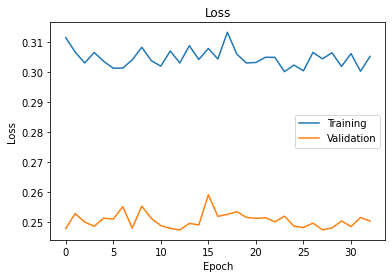

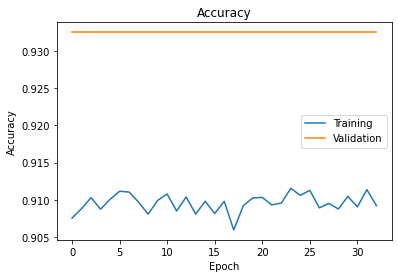

In [18]:
plot_history(history)

# Tensorboard

In [26]:
images, masks = val_gen.__getitem__(0)
np.expand_dims(images, axis=3).shape

(2, 512, 512, 1)

1/1 [==============================] - 0s 36ms/step


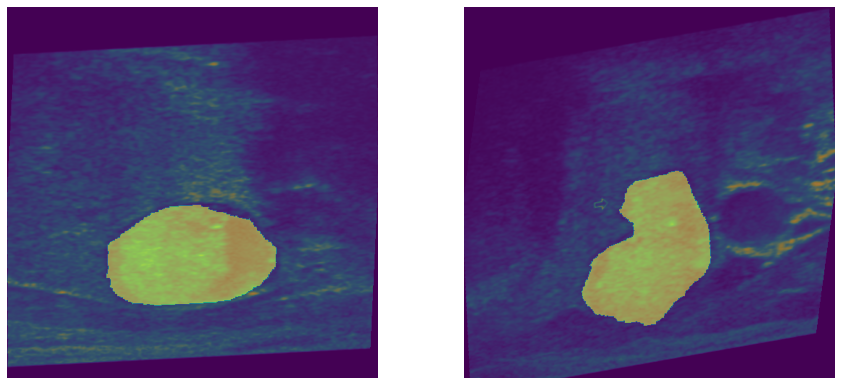

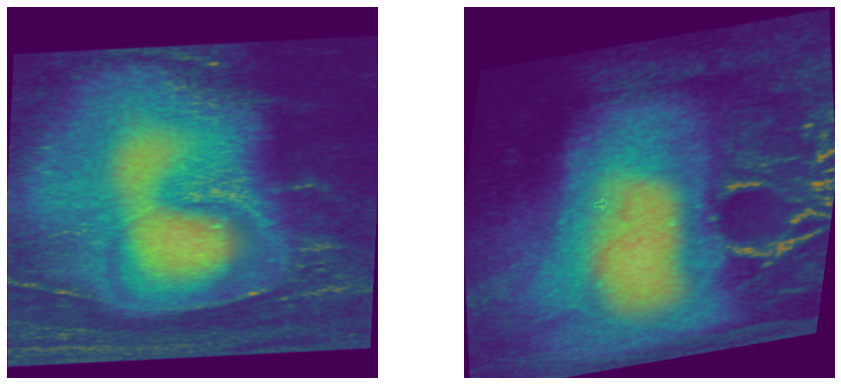

In [27]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(np.expand_dims(images, axis=3))

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

1/1 [==============================] - 0s 37ms/step


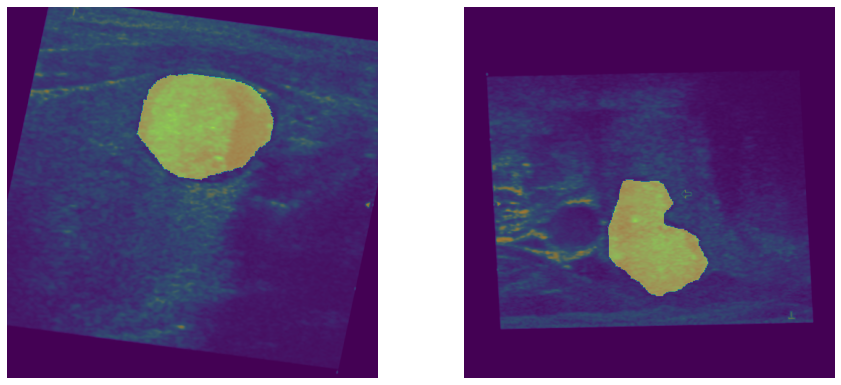

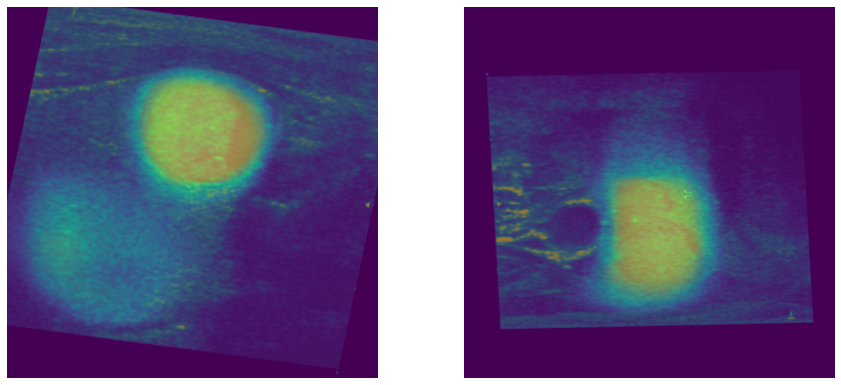

In [95]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

1/1 [==============================] - 0s 35ms/step


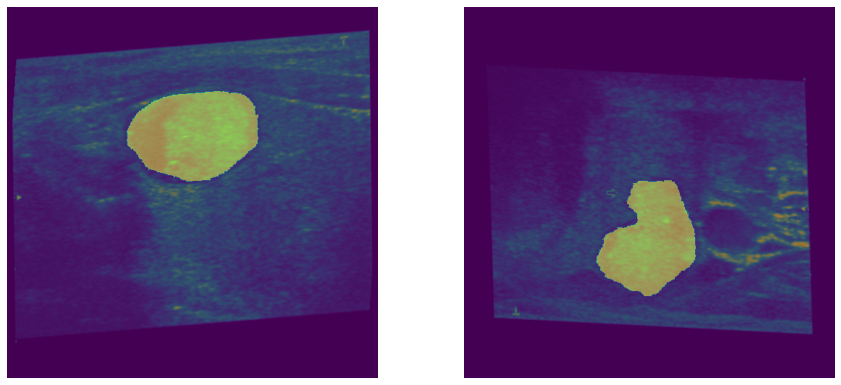

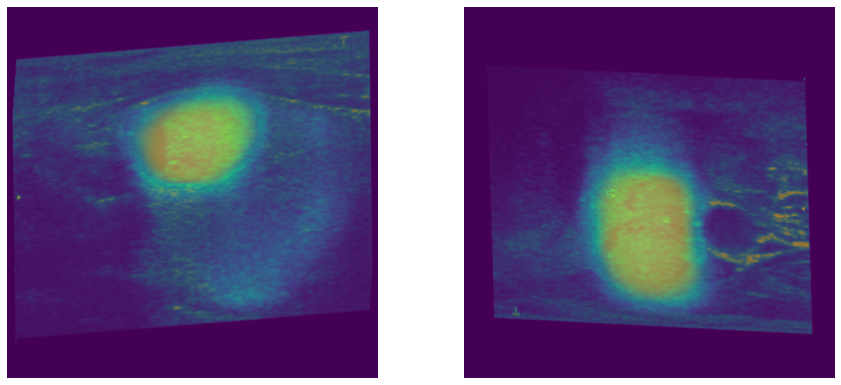

In [71]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

1/1 [==============================] - 0s 40ms/step


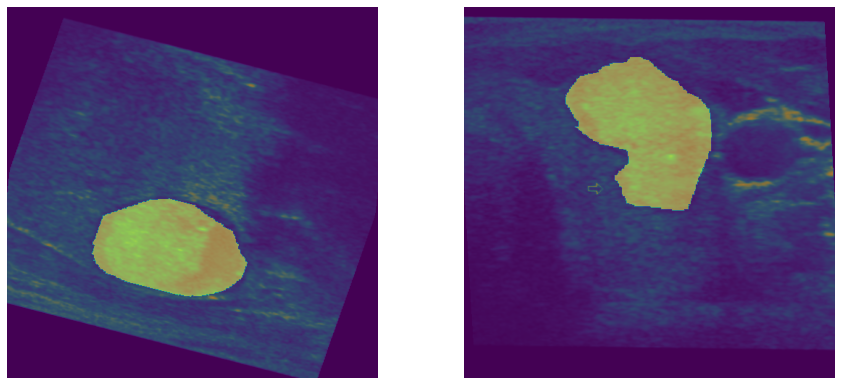

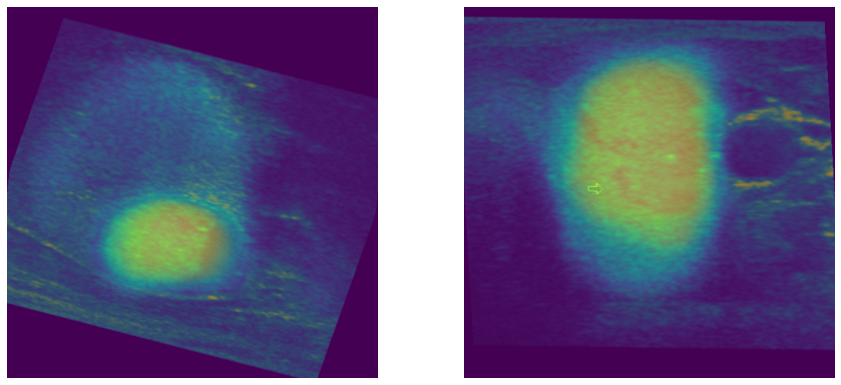

In [63]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

1/1 [==============================] - 0s 37ms/step


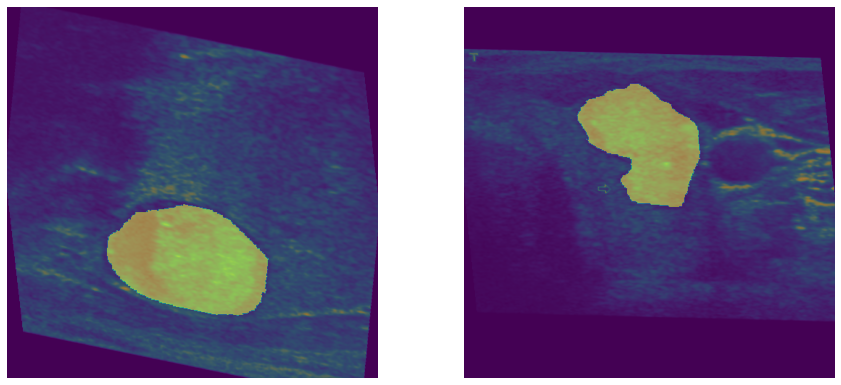

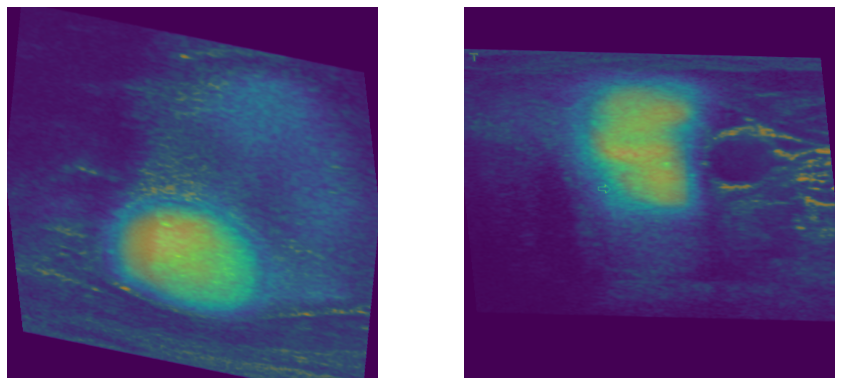

In [59]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

1/1 [==============================] - 0s 38ms/step


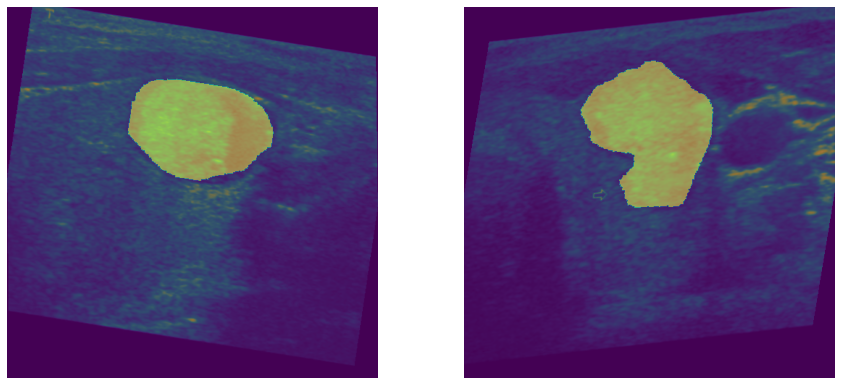

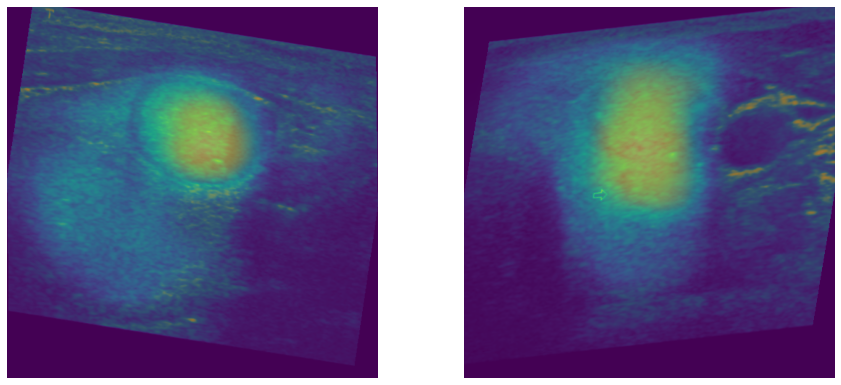

In [56]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

1/1 [==============================] - 0s 34ms/step


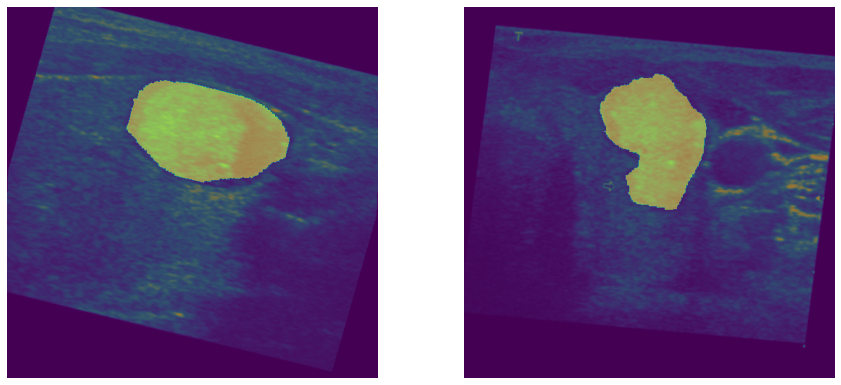

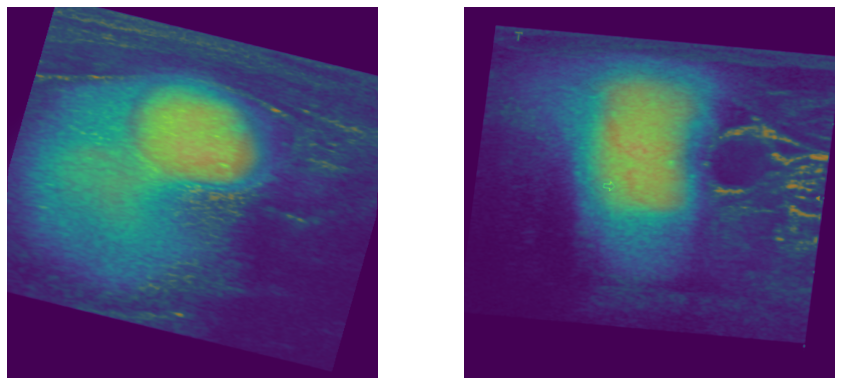

In [52]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

1/1 [==============================] - 0s 35ms/step


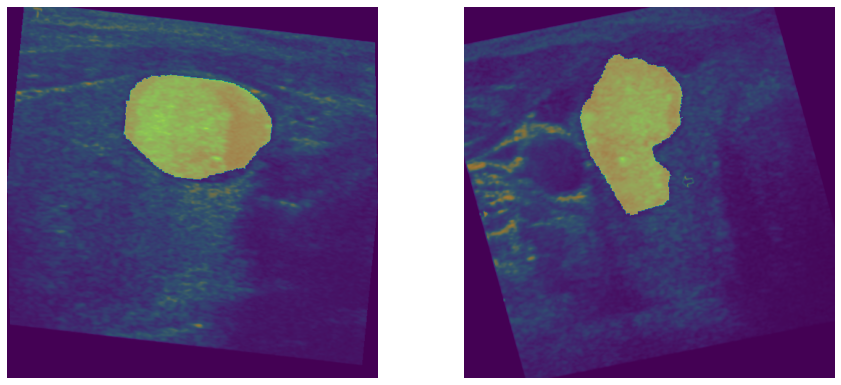

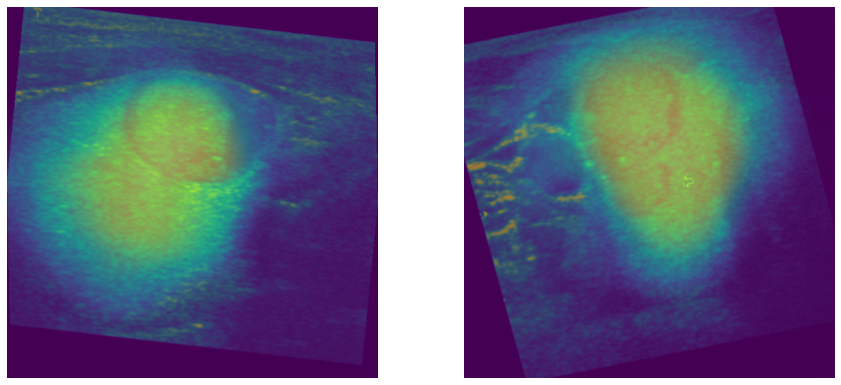

In [49]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

In [96]:
u2net_2d_model.save('unet_collection/models/u2net_2d_model')

INFO:tensorflow:Assets written to: unet_collection/models/u2net_2d_model/assets


INFO:tensorflow:Assets written to: unet_collection/models/u2net_2d_model/assets


1/1 [==============================] - 0s 36ms/step


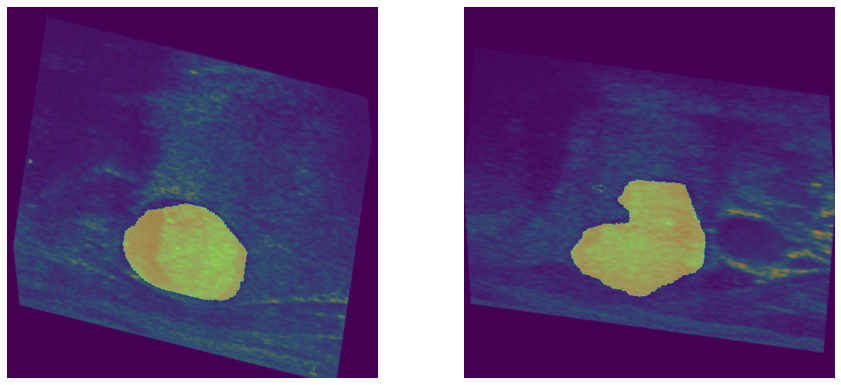

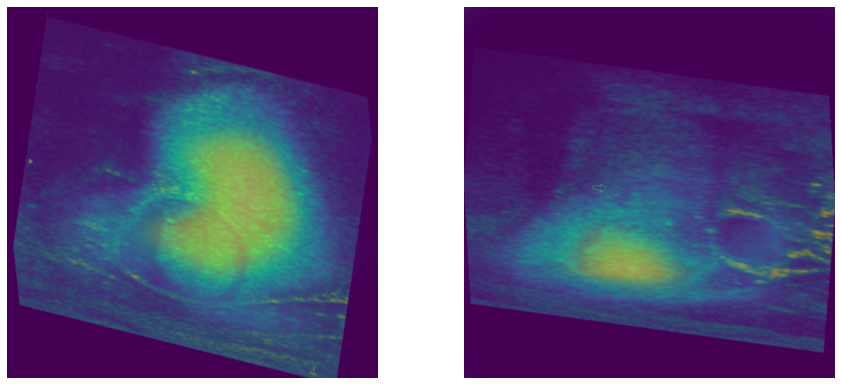

In [32]:
images, masks = val_gen.__getitem__(0)
predictions = u2net_2d_model.predict(images)

i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

i = 0
plt.figure(figsize=(15, 15))
for image, pred in zip(images, predictions):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()